In [26]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import datetime

In [55]:
import itertools
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import pearsonr
from scipy.stats import spearmanr

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse_log(prediction, target):
    return np.sqrt(mean_squared_log_error(target, prediction))

def pbias(list_sim, list_obs):
    if (len(list_sim) != len(list_obs)):
        print("not the same length between observed and simulated")
        print("len(list_obs) = ",len(list_obs))
        print("len(list_sim) = ",len(list_sim))
        return None
    delta = 0.
    sum_obs = 0.
    for i in range(len(list_sim)):
        delta += list_sim[i] - list_obs[i]
        sum_obs += list_obs[i]
    return 100*delta / sum_obs

In [29]:
s3bands = [
    'B1-400',
    'B2-412.5',
    'B3-442.5',
    'B4-490',
    'B5-510',
    'B6-560',
    'B7-620',
    'B8-665',
    'B9-673.75',
    'B10-681.25',
    'B11-708.75',
    'B12-753.75',
    'B16-778.75',
    'B17-865',
    'B18-885',
    'B21-1020'
]


In [27]:
def datafolder_2_list(path):
    return [f for f in path.iterdir() if f.suffix == '.csv']


def open_radiometry(path):
    old_names = [f'Oa{str(i).zfill(2)}_reflectance:float' for i in range(1, 22)]
    [old_names.remove(f'Oa{str(i).zfill(2)}_reflectance:float') for i in range(13,16)]
    [old_names.remove(f'Oa{str(i).zfill(2)}_reflectance:float') for i in range(19,21)]
    df = pd.read_csv(path).rename(columns={old_names[i]: s3bands[i] for i in range(16)})    
    return df


def normalize(df, bands, norm_band):
    df = df.copy()
    df[bands] = df[bands].to_numpy() - df[norm_band].to_numpy()[..., None]
    return df


def clip_negatives(df, bands, threshold=-0.1):
    return df.loc[~((df[bands] < -0.1).any(axis=1))]


def clean_radiometry(df, min_threshold=-0.1, norm_band='B21-1020'):

    if norm_band is not None:
        df = normalize(df, s3bands, 'B21-1020')

    df = clip_negatives(df, s3bands, -0.1)

    return df


def load_radiometries(path, min_pixels=5):

    csvs = [f for f in path.iterdir()]

    radiometries = {}

    for i, csv in enumerate(csvs):
        df = open_radiometry(csvs[i])
        if len(df) > min_pixels:
            radiometries[csv.stem[16:24]] = df
            
    return radiometries


def calc_nd_index(df, band1, band2, column_name='nd_index'):
    idx = (df[band1]-df[band2])/(df[band1]+df[band2])
    df[column_name] = idx
    
    
def db_scan(df, bands, column_name='cluster', eps=0.1, min_samples=5):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df[bands])
    df[column_name] = clustering.labels_
    

def power(x, a, b, c):return a*(x)**(b) + c


def SPM_GET_Amazon(b665, b865, cutoff_value=0.027, cutoff_delta=0.007, low_params=None, high_params=None, debug=False):

    if debug:
        pdb.set_trace()

    if cutoff_delta == 0:
        transition_coef = np.where(b665<=cutoff_value, 0, 1)

    else:
        transition_range = (cutoff_value - cutoff_delta, cutoff_value + cutoff_delta)
        transition_coef = (b665-transition_range[0])/(transition_range[1]-transition_range[0])

        transition_coef = np.clip(transition_coef, 0, 1)


    # if params are not passed, use default params obtained from the Amazon dataset
    low_params = [2.79101975e+05, 2.34858344e+00, 4.20023206e+00] if low_params is None else low_params
    high_params = [848.97770516,   1.79293191,   8.2788616 ] if high_params is None else high_params

    #low = Fit.power(b665, *low_params).fillna(0)
    #high = Fit.power(b865/b665, *high_params).fillna(0)

    low = power(b665, *low_params).fillna(0)
    high = power(b865/b665, *high_params).fillna(0)


    spm = (1-transition_coef)*low + transition_coef*high
    return spm


# https://stackoverflow.com/questions/29387137/how-to-convert-a-given-ordinal-number-from-excel-to-a-date
def from_excel_ordinal(ordinal, _epoch0=datetime.datetime(1899, 12, 31)):
    if ordinal >= 60:
        ordinal -= 1  # Excel leap year bug, 1900 is not a leap year!
    return (_epoch0 + datetime.timedelta(days=ordinal)).replace(microsecond=0)

In [28]:
pd.options.mode.chained_assignment = None  # default='warn'

def create_time_series_cluster(radiometries, bands=['B17-865', 'B21-1020'], eps=0.01, min_samples=5, save_folder=None, spm_vertex=None):
    df = pd.DataFrame()

    for date, radiometry in radiometries.items():

        if len(radiometry) < min_samples:
            continue 
        
        if spm_vertex:
            plot_spm_map(df=radiometry,
                         spm_vertex=spm_vertex,
                         title=date,
                         path2save=f'{save_folder/date}_spmap.png')
        
        db_scan(radiometry, bands, eps=eps, min_samples=min_samples)
        clusters = radiometry.groupby(by='cluster').mean()
        
        # drop the noise
        clusters.drop(-1, inplace=True, errors='ignore')

        # if there is at least 1 valid cluster
        if len(clusters) > 0:
            df = df.append(clusters[clusters['B21-1020'] == clusters['B21-1020'].min()].iloc[0].rename(date))
        
    
    df['Datestr'] = [f'{i[:4]}-{i[4:6]}-{i[6:]}' for i, row in df.iterrows()]
    df['Date'] = pd.to_datetime(df['Datestr'])
    df.sort_values(by='Date', inplace=True)
    df.reset_index(inplace=True)
    
    return df

In [80]:
df_mod_srtd.columns

Index(['Date', 'Nom', 'Bande rouge estimee', 'Bande IR estimee',
       'ecarttype bande rouge estimee', 'ecarttype bande IR estimee',
       'reflectance Bande rouge initiale', 'reflectance Bande IR initiale',
       'taille cluster', 'vzen', 'std(vzen)', 'numero scenario', 'sunglint',
       'pourcentage pixel valides', 'bande qualite 500m',
       'taille cluster/taillepixelvalide', 'flag qualite', 'Unnamed: 17',
       'reason for flag quality <> 1', 'Datetime'],
      dtype='object')

In [63]:
versions = {}

df_vfin = pd.read_excel(Path('/d_drive_data/processing/linux/14100000_manacapuru_v-fin.xlsx'), sheet_name='v-fin')
df_vfin = df_vfin[df_vfin['quality'] == 1].copy()
versions['final'] = df_vfin

df_vaot = pd.read_excel(Path('/d_drive_data/processing/linux/14100000_manacapuru_v-aot.xlsx'),sheet_name='v-aot')
df_vaot = df_vaot[df_vaot['quality'] == 1].copy()
versions['v-aot'] = df_vaot

df_vb11 = pd.read_excel(Path('/d_drive_data/processing/linux/14100000_manacapuru_v-b11.xlsx'), sheet_name='v-b11')
df_vb11 = df_vb11[df_vb11['quality'] == 1].copy()
versions['v-b11'] = df_vb11

df_vdwi = pd.read_excel(Path('/d_drive_data/processing/linux/14100000_manacapuru_v-ndwi.xlsx'), sheet_name='v-ndwi')
df_vdwi = df_vdwi[df_vdwi['quality'] == 1].copy()
versions['v-dwi'] = df_vdwi

df_vcms = pd.read_excel(Path('/d_drive_data/processing/linux/14100000_manacapuru_vv-cams.xlsx'), sheet_name='vv-cams')
df_vcms = df_vcms[df_vcms['quality'] == 1].copy()
versions['v-cms'] = df_vcms

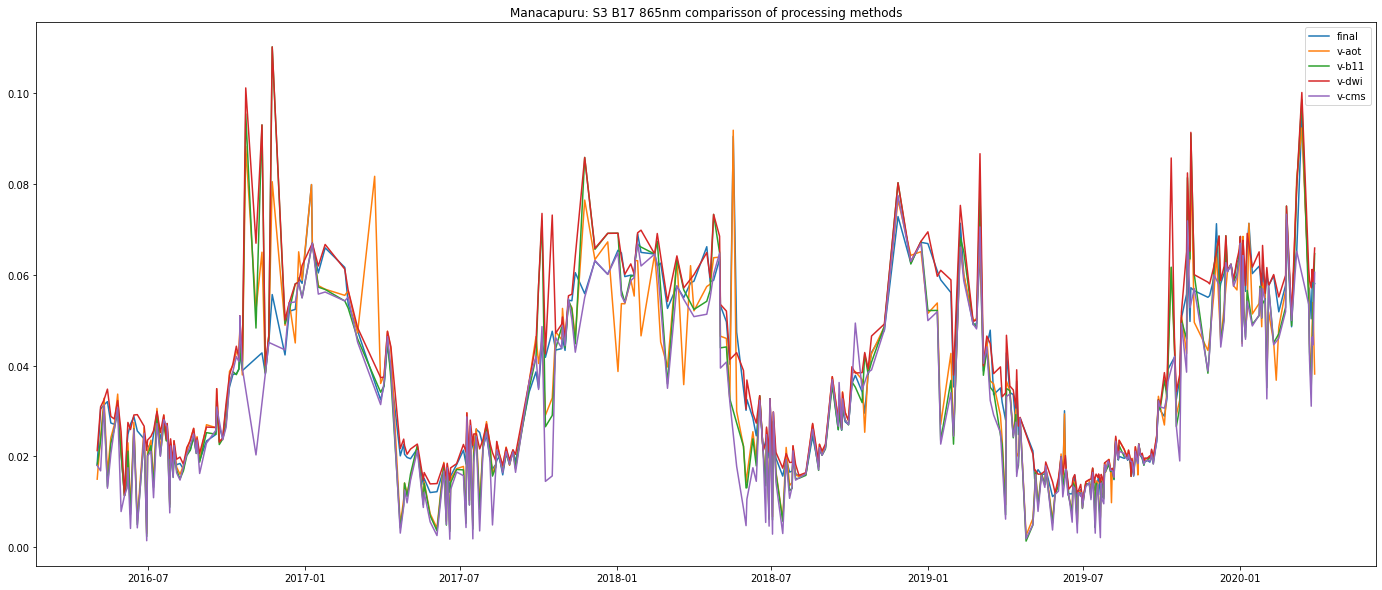

In [66]:
plt.rcParams['figure.figsize'] = [24, 10]
plt.title('Manacapuru: S3 B17 865nm comparisson of processing methods')
for key in versions:
    plt.plot(versions[key]['Datetime'], versions[key]['B17-865'], label=key)

plt.legend()
plt.show()

In [98]:
# MODIS-Terra
f_mod = '/d_drive_data/processing/OTHER_PLATFORMS/manacapuru_noinf/14100000_MOD09Q1_commun_noinf.xls'
df_mod = pd.read_excel(f_mod,sheet_name='MOD09Q1', converters={'Date': str})
df_mod['Date'] = df_mod['Nom'].apply(lambda x: datetime.datetime.strptime(x.split('_')[2][1:], '%Y%j').date())
df_mod_srtd = df_mod.sort_values(by='Date')
df_mod_srtd['Datetime'] = pd.to_datetime(df_mod_srtd['Date'], errors='coerce')
df_mod_srtd = df_mod_srtd[(df_mod_srtd['flag qualite'] == 1) | (df_mod_srtd['flag qualite'] == 2)].copy()

# MODIS-Aqua
f_myd = '/d_drive_data/processing/OTHER_PLATFORMS/manacapuru_noinf/14100000_MYD09Q1_commun_noinf.xls'
df_myd = pd.read_excel(f_myd,sheet_name='MYD09Q1', converters={'Date': str})
df_myd['Date'] = df_myd['Nom'].apply(lambda x: datetime.datetime.strptime(x.split('_')[2][1:], '%Y%j').date())
df_myd_srtd = df_myd.sort_values(by='Date')
df_myd_srtd['Datetime'] = pd.to_datetime(df_myd_srtd['Date'], errors='coerce')
df_myd_srtd = df_myd_srtd[(df_myd_srtd['flag qualite'] == 1) | (df_myd_srtd['flag qualite'] == 2)].copy()

# VIIRS
f_vir = '/d_drive_data/processing/OTHER_PLATFORMS/manacapuru_noinf/14100000_VNP09H1_commun_noinf.xls'
df_vir = pd.read_excel(f_vir,sheet_name='Report', converters={'Date': str})
df_vir['Date'] = df_vir['Nom'].apply(lambda x: datetime.datetime.strptime(x.split('_')[2][1:], '%Y%j').date())
df_vir_srtd = df_vir.sort_values(by='Date')
df_vir_srtd['Datetime'] = pd.to_datetime(df_vir_srtd['Date'], errors='coerce')
df_vir_srtd = df_vir_srtd[(df_vir_srtd['flag qualite'] == 1) | (df_vir_srtd['flag qualite'] == 2)].copy()

In [99]:
df_mod_out = df_mod_srtd[(df_mod_srtd['Datetime'] < df_vfin['Datetime'].min()) | (df_mod_srtd['Datetime'] > df_vfin['Datetime'].max())].index
df_mod_ytrue = df_mod_srtd.copy()
df_mod_ytrue.drop(df_mod_out, inplace=True)
len(df_mod_out)

684

In [100]:
df_myd_out = df_myd_srtd[(df_myd_srtd['Datetime'] < df_vfin['Datetime'].min()) | (df_myd_srtd['Datetime'] > df_vfin['Datetime'].max())].index
df_myd_ytrue = df_myd_srtd.copy()
df_myd_ytrue.drop(df_myd_out, inplace=True)
len(df_myd_out)

616

In [101]:
df_vir_out = df_vir_srtd[(df_vir_srtd['Datetime'] < df_vfin['Datetime'].min()) | (df_vir_srtd['Datetime'] > df_vfin['Datetime'].max())].index
df_vir_ytrue = df_vir_srtd.copy()
df_vir_ytrue.drop(df_vir_out, inplace=True)
len(df_vir_out)

183

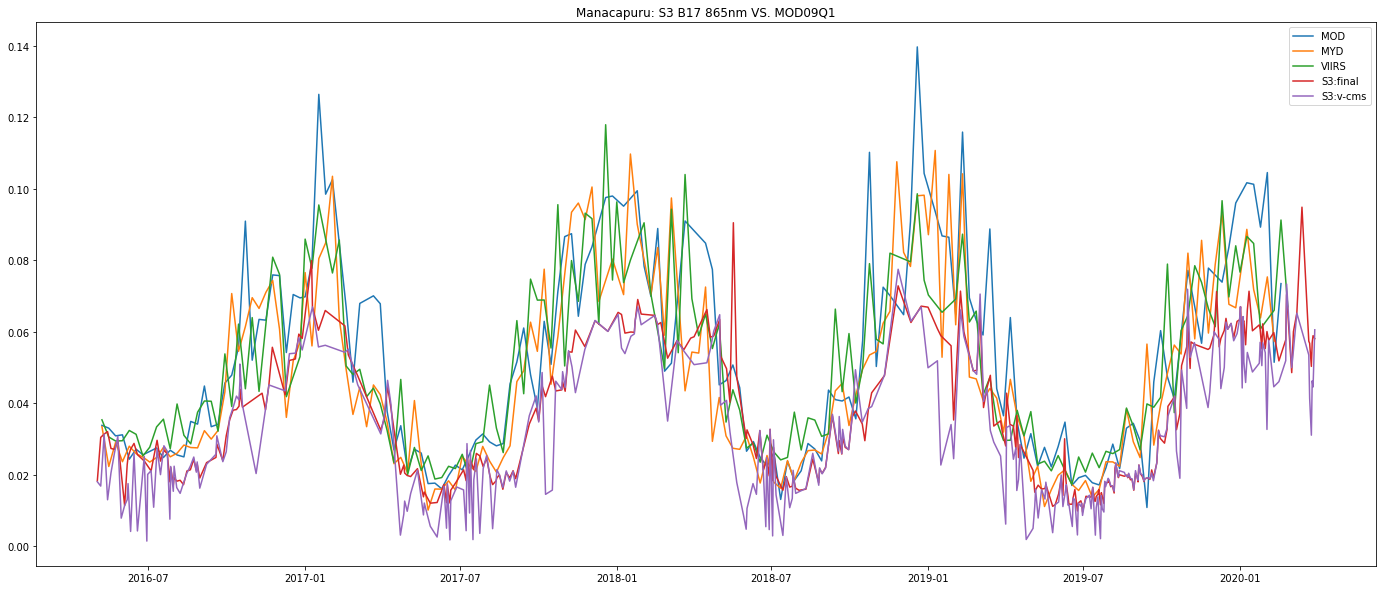

In [103]:
plt.rcParams['figure.figsize'] = [24, 10]
plt.title('Manacapuru: S3 B17 865nm VS. MOD09Q1')

plt.plot(df_mod_ytrue['Date'], df_mod_ytrue['Bande IR estimee']/10000, label='MOD')
plt.plot(df_myd_ytrue['Date'], df_myd_ytrue['Bande IR estimee']/10000, label='MYD')
plt.plot(df_vir_ytrue['Date'], df_vir_ytrue['Bande IR estimee']/10000, label='VIIRS')
plt.plot(versions['final']['Datetime'], versions['final']['B17-865'], label='S3:final')
plt.plot(versions['v-cms']['Datetime'], versions['v-cms']['B17-865'], label='S3:v-cms')

plt.legend()
plt.show()

In [19]:
def _spm_modis(nir, red):
    return 759.12 * ((nir / red) ** 1.92)

def _power(x, a, b, c):
    return a * (x) ** (b) + c

def get_spm(band665, band865, cutoff_value=0.027, cutoff_delta=0.007, low_params=None, high_params=None):

    b665 = band665 / np.pi
    b865 = band865 / np.pi

    if cutoff_delta == 0:
        transition_coef = np.where(b665 <= cutoff_value, 0, 1)

    else:
        transition_range = (cutoff_value - cutoff_delta, cutoff_value + cutoff_delta)
        transition_coef = (b665 - transition_range[0]) / (transition_range[1] - transition_range[0])

        transition_coef = np.clip(transition_coef, 0, 1)

    # if params are not passed, use default params obtained from the Amazon dataset
    low_params = [2.79101975e+05, 2.34858344e+00, 4.20023206e+00] if low_params is None else low_params
    high_params = [848.97770516, 1.79293191, 8.2788616] if high_params is None else high_params

    # low = Fit.power(b665, *low_params).fillna(0)
    # high = Fit.power(b865/b665, *high_params).fillna(0)

    low = _power(b665, *low_params).fillna(0)
    # high = power(b865/b665, *high_params).fillna(0)
    high = _spm_modis(b865, b665)

    spm = (1 - transition_coef) * low + transition_coef * high
    return spm

In [68]:
for key in versions:
    versions[key]['SPM'] = get_spm(versions[key]['B8-665'], versions[key]['B17-865'])

In [39]:
manacapuru_sed_xls = Path('/d_drive_data/processing/linux/14100000_manacapuru_v15_sedimentos.xlsx')
# manacapuru_sed_xls = Path('D:/processing/linux/14100000_manacapuru_v15_sedimentos.xlsx')
# sed_xls = '/d_drive_data/processing/linux/14100000_manacapuru_v15.xlsx'
df_manacapuru_sed = pd.read_excel(manacapuru_sed_xls,sheet_name='sedimentos')
# Fix excel dates from ordinal (40603) to datetime.datetime(2011, 3, 1, 0, 0)
df_manacapuru_sed['pydate'] = [from_excel_ordinal(d) for d in df_manacapuru_sed['Data']]
# Reorder the DF by datetime 
df_manacapuru_sed.sort_values(by='pydate', inplace=True)
len(df_manacapuru_sed)

363

In [40]:
hyb_sed_out = df_manacapuru_sed[(df_manacapuru_sed['pydate'] > df_vfin['Datetime'].max()) | (df_manacapuru_sed['pydate'] < df_vfin['Datetime'].min())].index
df_sed = df_manacapuru_sed.copy()
df_sed.drop(hyb_sed_out, inplace=True)
len(df_sed)

140

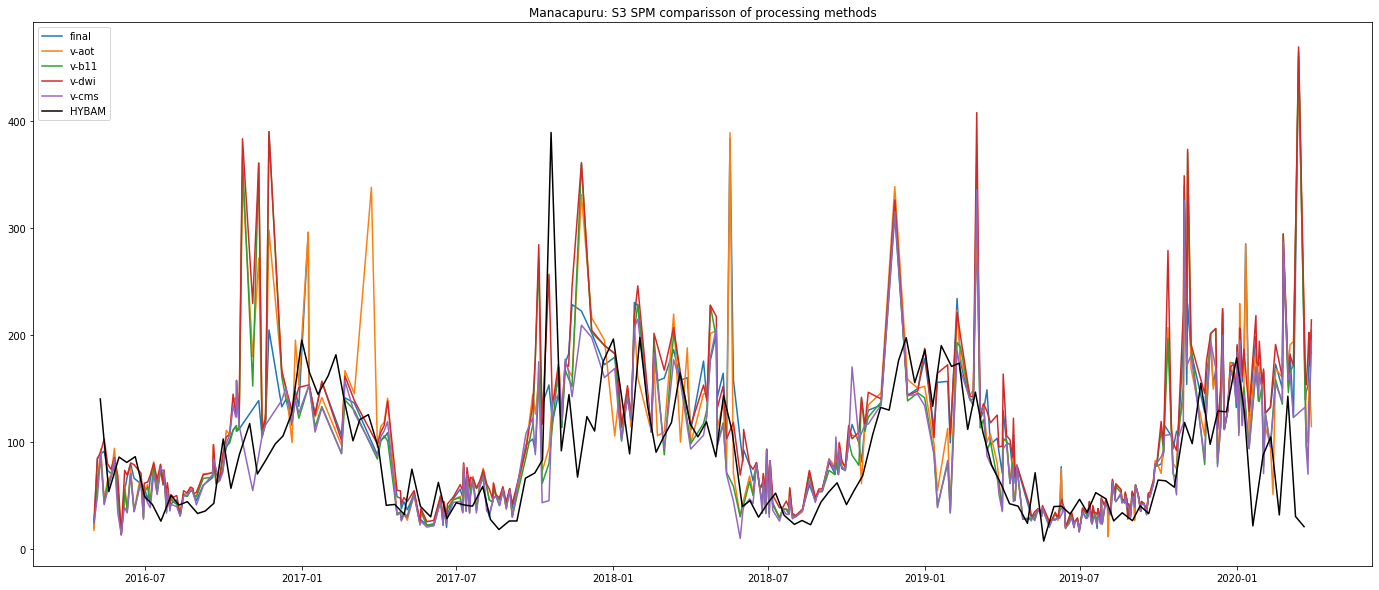

In [70]:
plt.rcParams['figure.figsize'] = [24, 10]
plt.title('Manacapuru: S3 SPM comparisson of processing methods')
for key in versions:
    plt.plot(versions[key]['Datetime'], versions[key]['SPM'], label=key)

plt.plot(df_sed['pydate'],df_sed['Concentração (mg/L)'], c='k', label='HYBAM')
plt.legend()

In [50]:
# Get the SPM y-true ground-truth
y_true_sed = df_manacapuru_sed.copy()
# Create a datetime column
y_true_sed.index = [t.replace(hour=12,minute=0,second=0,microsecond=0) for t in y_true_sed['pydate']]
y_true_sed.index.rename('Date')
# Sort by ascending from 2016 to present
y_true_sed.sort_index(inplace=True, ascending=True)
# Slice by date using the DBSCAN DF as a limit
y_true_sed = y_true_sed.loc[df_vfin['Datetime'].min():df_vfin['Datetime'].max()]

In [71]:
for key in versions:
    versions[key]['Date'] = [t.replace(hour=12,minute=0,second=0,microsecond=0) for t in versions[key]['Datetime']]

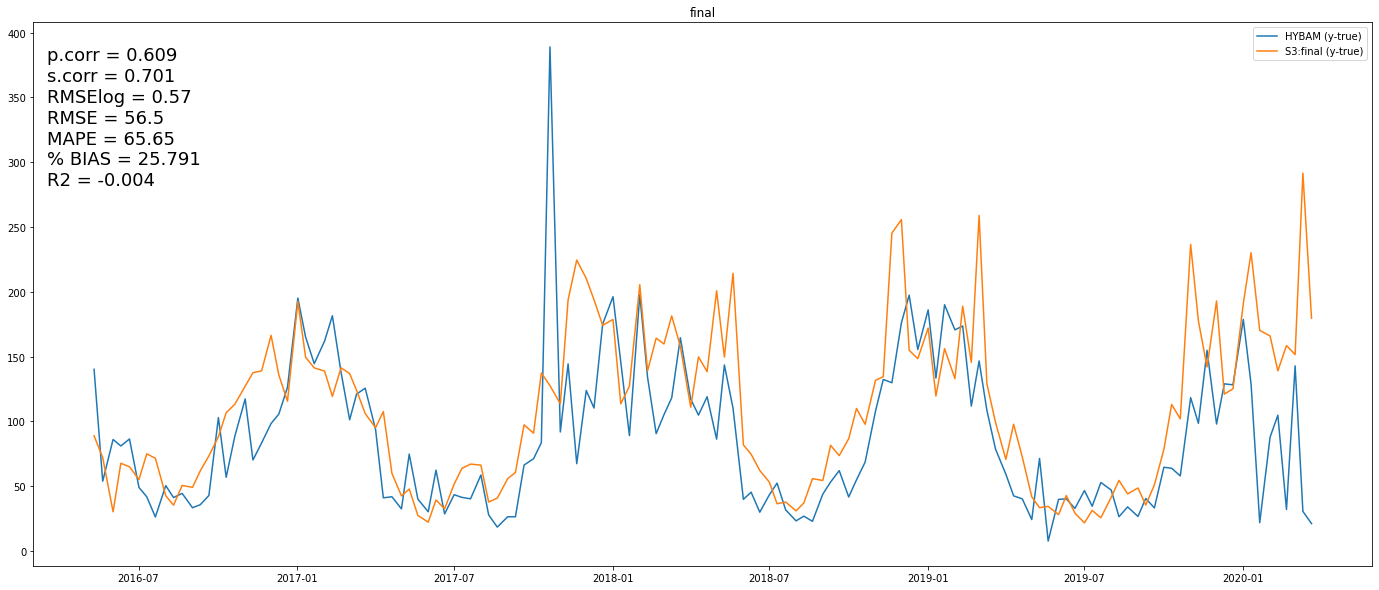

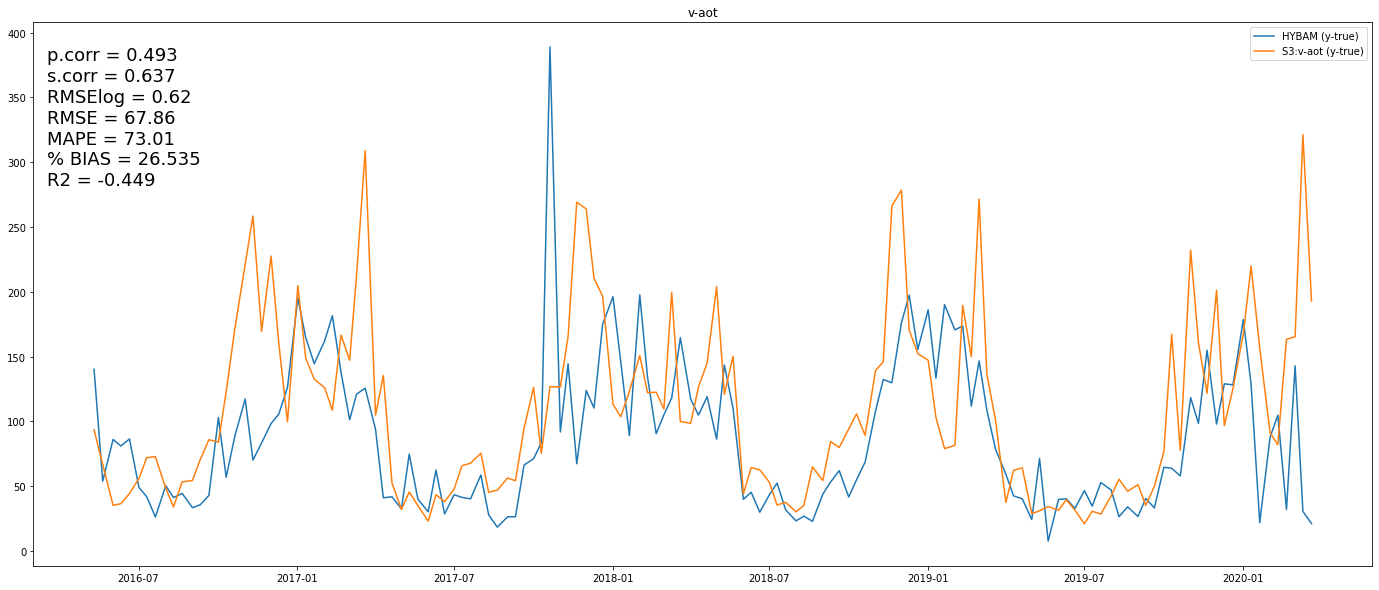

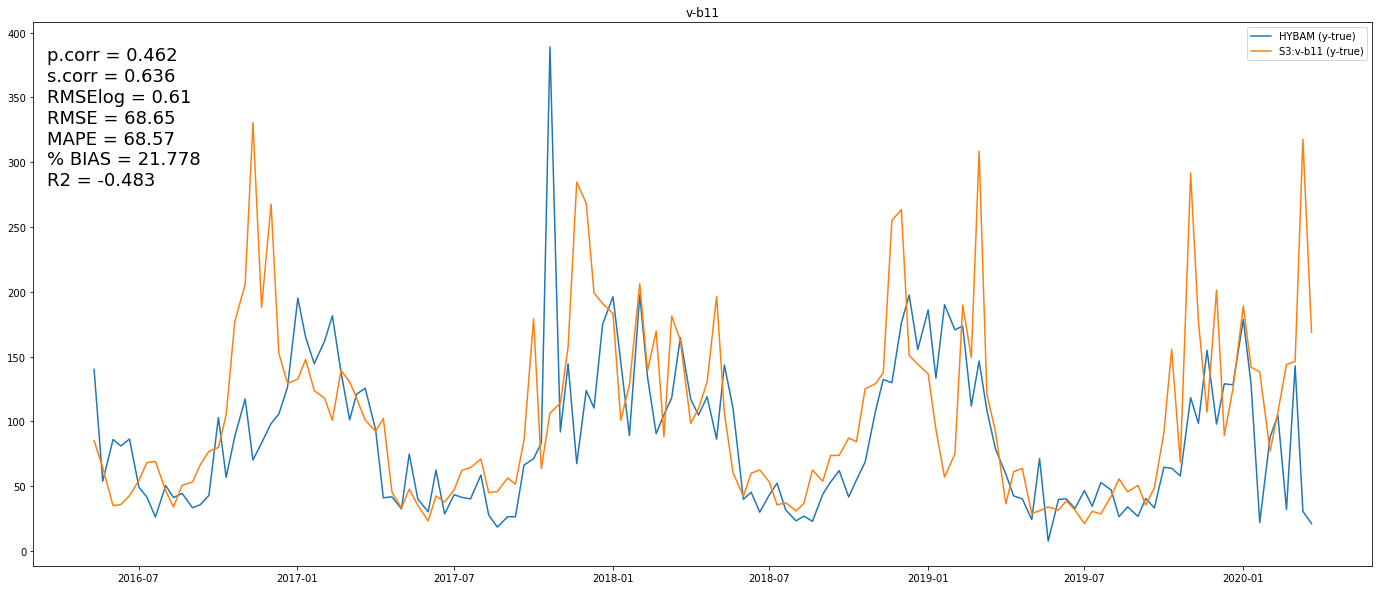

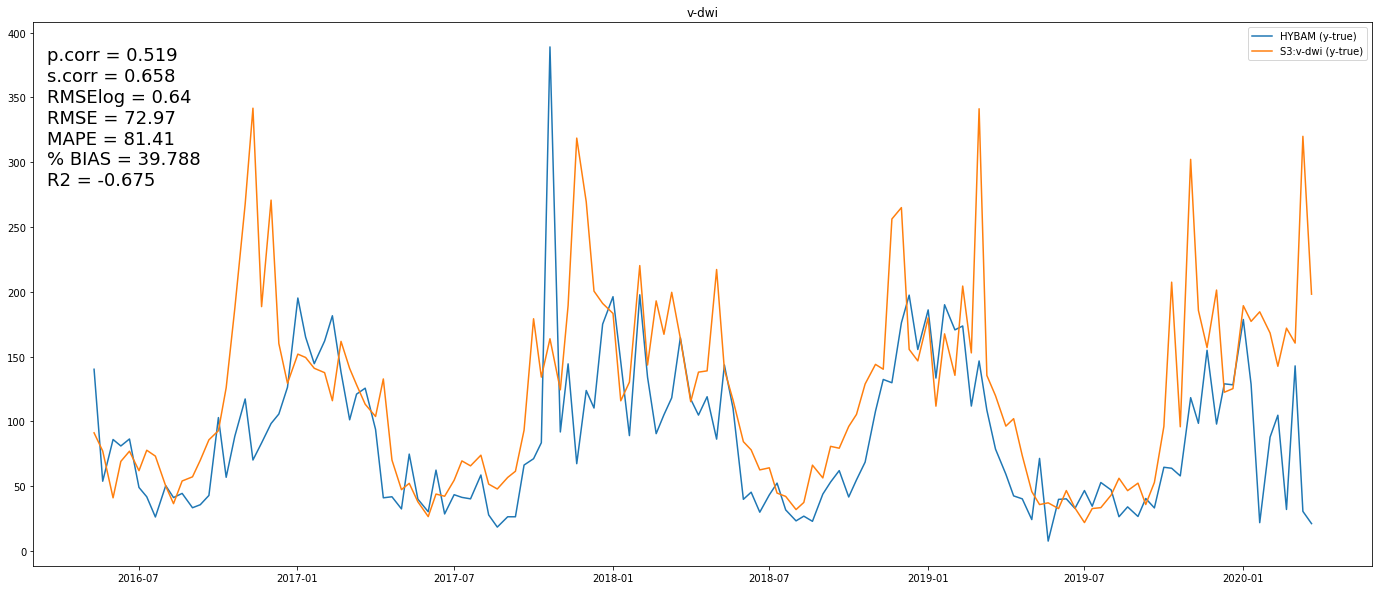

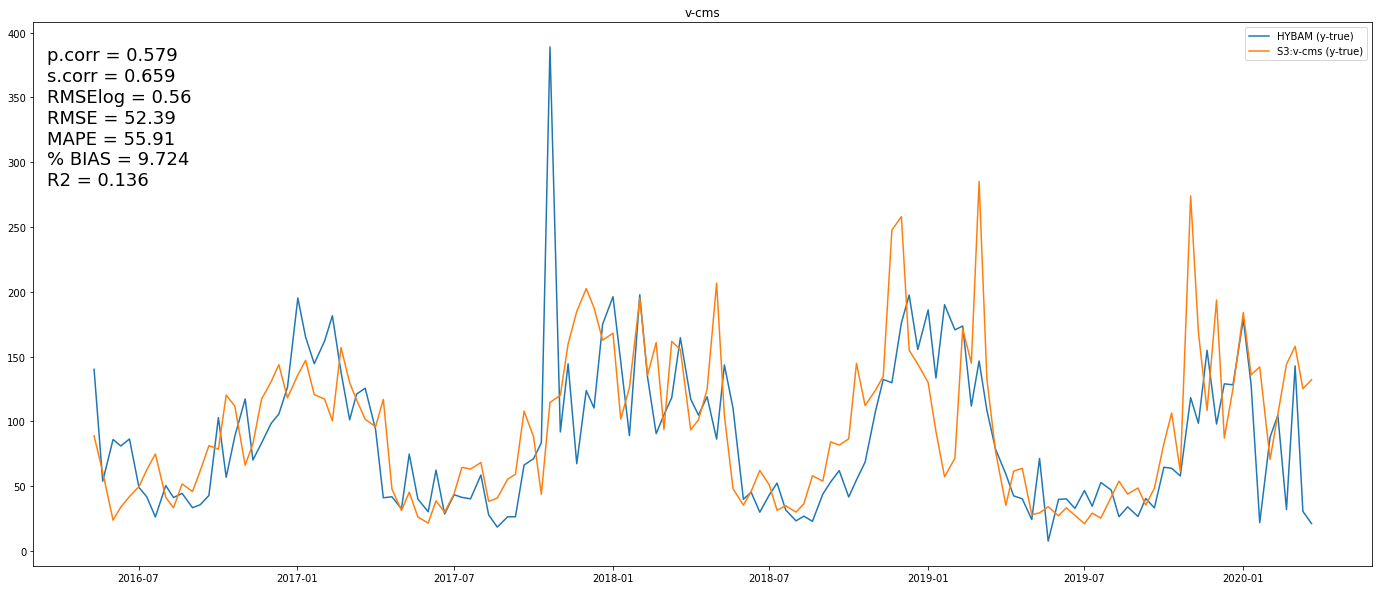

In [113]:
row_result = {}

for key in versions:
    ################################################
    # STATISTICAL TESTS USING INTERPOLATED PAIRING #
    ################################################
    # copy only the SPM column to a new pd.series
    s3spm = versions[key]['SPM']
    # set the series index to datetime
    s3spm.index = versions[key]['Date']
    # create a range of daily events to be used as indexer
    idx = pd.date_range(start=versions[key]['Date'].min(),end=versions[key]['Date'].max(),freq='D')
    # use the range as an index for a new pandas series
    daily_s3_spm = pd.Series(np.nan, index=idx)
    # spread the satelite measures over its respective days using the previously created indexer
    daily_s3_spm[s3spm.index] = s3spm
    # fill the NaNs by linear interpolation
    daily_s3_spm.interpolate(method='time', inplace=True)
    # create S3:SPM series containing the matching HYBAM:SPM
    y_pred_itr = daily_s3_spm[y_true_sed.index]
    y_true_itr = y_true_sed['Concentração (mg/L)']
    # drop NaNs
    ytp_iter = pd.DataFrame({'y_true':y_true_itr, 'y_pred':y_pred_itr})
    ytp_iter.dropna(inplace=True)
    y_true_itr = ytp_iter['y_true'].copy()
    y_pred_itr = ytp_iter['y_pred'].copy()
    del ytp_iter
    
    # save results to dict
    row_result['itr_pcorr'], _ = pearsonr(y_true_itr, y_pred_itr)
    row_result['itr_scorr'], _ = spearmanr(y_true_itr, y_pred_itr)
    row_result['itr_rmse_log'] = rmse_log(y_pred_itr, y_true_itr)
    row_result['itr_rmse'] = rmse(y_pred_itr, y_true_itr)
    row_result['itr_mape'] = mape(y_true_itr, y_pred_itr)
    row_result['itr_pbias'] = pbias(y_pred_itr, y_true_itr)
    row_result['itr_r2'] = r2_score(y_true_itr, y_pred_itr)

    # generate scatter texts
    txt_itr_pcorr = str(round(row_result['itr_pcorr'],3))
    txt_itr_scorr = str(round(row_result['itr_scorr'],3))
    txt_itr_rmselog = str(round(row_result['itr_rmse_log'],2))
    txt_itr_rmse = str(round(row_result['itr_rmse'],2))
    txt_itr_mape = str(round(row_result['itr_mape'],2))
    txt_itr_bias = str(round(row_result['itr_pbias'],3))
    txt_itr_r2 = str(round(row_result['itr_r2'],3))

    stats_txt = f'p.corr = {txt_itr_pcorr}\ns.corr = {txt_itr_scorr}\nRMSElog = {txt_itr_rmselog}\nRMSE = {txt_itr_rmse}\nMAPE = {txt_itr_mape}\n% BIAS = {txt_itr_bias}\nR2 = {txt_itr_r2}'
    
    plt.title(f'{key}')
    plt.plot(y_true_itr, label='HYBAM (y-true)')
    plt.plot(y_pred_itr, label=f'S3:{key} (y-true)')
    plt.annotate(text=stats_txt, xycoords='axes fraction', xy=(0.01,0.7), size=18)
    plt.legend()
    plt.show()

## SPM André

In [115]:
vld_andre = {
    '28-02-2016': 181.99,
    '28-02-2016': 236.76,
    '28-02-2016': 310.31,
    '28-02-2016': 425.33,
    '28-02-2016': 198.97,
    '06-02-2017': 216.14,
    '06-02-2017': 258.87,
    '06-02-2017': 151.97,
    '10-04-2017': 76.60,
    '10-04-2017': 104.40,
    '10-04-2017': 48.20,
    '06-10-2017': 77.89,
    '06-10-2017': 102.13,
    '06-10-2017': 86.14,
    '03-02-2018': 178.80,
    '03-02-2018': 319.23,
    '03-02-2018': 216.56,
    '16-03-2018': 149.20,
    '16-03-2018': 198.00,
    '16-03-2018': 178.80,
    '16-03-2018': 100.60,
    '26-04-2018': 147.20,
    '26-04-2018': 189.60,
    '26-04-2018': 169.20,
    '26-04-2018': 102.40,
    '25-05-2018': 103.00,
    '25-05-2018': 119.40,
    '25-05-2018': 66.00,
    '25-05-2018': 66.80,
    '14-06-2018': 76.00,
    '14-06-2018': 70.80,
    '14-06-2018': 114.60,
    '14-06-2018': 60.20,
    '22-07-2018': 8.20,
    '22-07-2018': 7.20,
    '22-07-2018': 71.60,
    '22-07-2018': 42.40,
    '04-09-2018': 40.80,
    '04-09-2018': 64.60,
    '04-09-2018': 85.00,
    '04-09-2018': 40.20,
    '14-02-2019': 121.40,
    '14-02-2019': 172.80,
    '14-02-2019': 215.80,
    '14-02-2019': 133.80,
    '12-03-2019': 98.00,
    '12-03-2019': 174.20,
    '12-03-2019': 119.80,
    '12-03-2019': 71.80,
    '21-04-2019': 50.60,
    '21-04-2019': 23.00,
    '21-04-2019': 49.60,
    '21-04-2019': 19.80,
    '17-05-2019': 27.60,
    '17-05-2019': 59.60,
    '17-05-2019': 54.80,
    '17-05-2019': 30.60,
    '21-06-2019': 28.60,
    '21-06-2019': 40.60,
    '21-06-2019': 35.80,
    '21-06-2019': 18.80,
    '18-07-2019': 34.60,
    '18-07-2019': 46.00
}

In [125]:
data = {'strDate':vld_andre.keys(),
        'SPM':vld_andre.values()}
 
# Create DataFrame
df = pd.DataFrame(data)